# Example ANN generation and training

From melon (https://git.rwth-aachen.de/avt-svt/public/MeLOn/-/tree/master/gaussian%20process), maingopy (https://git.rwth-aachen.de/avt-svt/public/maingo/-/tree/master/examples/05_GaussianProcess) and the GP paper (https://arxiv.org/pdf/2005.10902.pdf).

In [1]:
import utils
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from pyDOE import lhs
import torch
import gpytorch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import maingopy

Implement peaks function

In [2]:
def peaks(X):
    term1 = 3*np.multiply((1-X[:,0])**2, np.exp(-(X[:,0])**2-(X[:,1]+1)**2))
    term2 = np.multiply(-10*(X[:,0]/5-X[:,0]**3-X[:,1]**5), np.exp(-X[:,0]**2-X[:,1]**2))
    term3 = -np.exp(-(X[:,0]+1)**2-X[:,1]**2)/3
    y = term1 + term2 + term3
    return np.expand_dims(y, axis=-1)

In [3]:
# test global minimum at f(0.228, -1.626)=-6.551
peaks(np.array([[0.228, -1.626], [0.5,0.5]]))

array([[-6.55112995],
       [ 0.37537558]])

## Training data generation

Generate 20 samples with latin hypercube sampling, rescale to [-3, 3] and evaluate.

In [4]:
lhd = lhs(2, samples=50)
Xpeaks = lhd*6-3
ypeaks = peaks(Xpeaks)

In [5]:
# scale data and retain information to do ivnerse in the scaler object
scaler = dict()

# scale inputs to [0 , 1]
scaler['input'] = MinMaxScaler(feature_range=(0,1)) 
Xscaled = scaler['input'].fit_transform(Xpeaks)

# scale outputs to zero mean and unit variance
scaler['output'] = StandardScaler()
yscaled = scaler['output'].fit_transform(ypeaks.reshape(-1, 1)).squeeze()

## Load and set parameters

In [6]:
problem_name = 'peaks'
# dimensionality of the data
input_dim = 2
output_dim = 1
# scale Input to [-1,1] range
scaleInput = True
# normalize Output to z-score
normalizeOutput = True

## Set model parameters

In [7]:
# output filename
output_folder = "./data/GP/"
filename_out = output_folder + problem_name
# training parameters
MATERN = 5 # matern 5/2 covariance function

#learning parameters
N_TRAINING_ITER = 250 
LR = 0.1

## Build GP

In [8]:
#Traning data to torch
Xtrain = torch.from_numpy(Xscaled)
ytrain = torch.from_numpy(yscaled)

Model: exact GP with a marginal log likelihood, matern 5/2 covariance function and constant mean. 

In [9]:
class ExactGPModel(gpytorch.models.ExactGP): #definition of class
    def __init__(self, train_x, train_y, likelihood, matern): # def creates objects needed for forward
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        #super() returns a proxy class which inherits gpytorch.models.ExactGP, its parent
        #in short, we create a subclass by extending the parent
        self.mean_module = gpytorch.means.ConstantMean() # constant mean
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=matern/2, ard_num_dims = 2)
            )
        #self.covar_module = gpytorch.kernels.MaternKernel(nu=matern/2, ard_num_dims = 2) #matern class
        #we have flexible options for mean and covar module definition (i.e. with/without white noise, here or below
        
    def forward(self, x): #computes 
        mean_x = self.mean_module(x) #prior mean
        covar_x = self.covar_module(x)# + self.white_noise_module(x) #prior covariance matrix from kernels
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) #multivar normal

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(Xtrain, ytrain.squeeze(), likelihood, matern=MATERN)

## Train with adam

First-order gradient-based optimization of stochastic objective functions (https://arxiv.org/abs/1412.6980)

In [11]:
training_time = time.time()

# Find optimal model hyperparameters, put modle in training
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(N_TRAINING_ITER):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(*model.train_inputs)
    # Calc loss and backprop gradients
    loss = -mll(output, model.train_targets)
    loss.backward()
    if (i+1)%25 == 0:
        print('Iter %d/%d \n\tLoss:\t%s\n\tlengthscale:\t%s\n\tnoise:\t%s' % (
            i + 1, N_TRAINING_ITER, loss,
            model.covar_module.base_kernel.lengthscale,
            model.likelihood.noise
        ))
    optimizer.step()

training_time = training_time - time.time()

Iter 25/250 
	Loss:	tensor(1.0762, dtype=torch.float64, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.1133, 0.1074]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.1656], grad_fn=<AddBackward0>)
Iter 50/250 
	Loss:	tensor(0.9104, dtype=torch.float64, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.1504, 0.1385]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.0152], grad_fn=<AddBackward0>)
Iter 75/250 
	Loss:	tensor(0.8790, dtype=torch.float64, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.1441, 0.1369]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.0041], grad_fn=<AddBackward0>)
Iter 100/250 
	Loss:	tensor(0.8720, dtype=torch.float64, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.1455, 0.1376]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.0021], grad_fn=<AddBackward0>)
Iter 125/250 
	Loss:	tensor(0.8692, dtype=torch.float64, grad_fn=<NegBackward0>)
	lengthscale:	tensor([[0.1464, 0.1384]], grad_fn=<SoftplusBackward0>)
	noise:	tensor([0.0014], grad_fn=<AddBackward0>)
Ite

## Plot surrogate model

In [12]:
def compute_grid(lb, ub, npoints = 200):
    """computes peaks output in a grid to plot it"""
    vector1 = np.linspace(lb[0], ub[0], npoints)
    vector2 = np.linspace(lb[1], ub[1], npoints)
    test_grid_x1, test_grid_x2 = np.meshgrid(vector1, vector2)

    # positions = np.vstack([test_grid_x1.ravel(), test_grid_x2.ravel()])
    #np_test_x = (np.array(positions)).T
    #convert meshgrid to all possible pairwise combinations and input into the prediction model
    np_test_x = np.array([test_grid_x1, test_grid_x2]).T.reshape(-1,2)

    X_plot = test_grid_x2.reshape(np.size(test_grid_x2))
    Y_plot = test_grid_x1.reshape(np.size(test_grid_x1))
    
    return np.concatenate((np.expand_dims(X_plot, axis=-1), np.expand_dims(Y_plot, axis=-1)), axis=-1)

Xpeaks = compute_grid(lb=[-3,-3], ub=[3, 3], npoints = 35)
ypeaks = peaks(Xpeaks)

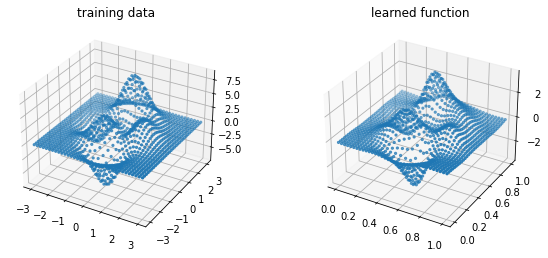

In [13]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GPplot = compute_grid(lb=[0,0], ub=[1, 1], npoints = 35)
X_plot = torch.cat((torch.from_numpy(GPplot[:,0]).unsqueeze(-1), torch.from_numpy(GPplot[:,1]).unsqueeze(-1)), axis=-1)
f_preds = model(X_plot) #mean of the model
y_preds = likelihood(model(X_plot)) # covariance of the model at X_plot

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
cmap = plt.get_cmap('coolwarm')
ax.scatter(Xpeaks[:,0], Xpeaks[:,1], ypeaks, marker=".")
ax.set_title('training data')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(GPplot[:,0], GPplot[:,1], y_preds.mean.detach().squeeze().numpy(), marker=".")
ax.set_title('learned function')
plt.show()

## Define optimization problem in maingopy

In the same way as ANN. i.e.: define the GP with melonpy, which gives the relaxations. Then pass on to maingopy which solves it globally with B&B in reduced space.

Convert model to be readable by melonpy. Essentially: a dictionary containing the trained hyperparameters (lenghtscales and input scaler), the training inputs and the scaler information, which is min and max of training data, mean and std dev of training data to normalize.


In [14]:
gp_model = utils.generate_melon_gp_object(model, Xtrain, ytrain, MATERN, scaler)
#alternatively: pass information as a json file.
utils.save_model_to_json(r"./data/GP", "testGP.json", model, Xtrain, ytrain, MATERN, scaler)

In [15]:
class Model(maingopy.MAiNGOmodel):
    #####################################
    # This function defines the optimization variables in the problem. In the above (MI)NLP, this corresponds to the x \in X part.
    # A variable typically needs bounds to define the host set X and can optionally have a variable type (VT_CONTINUOUS, VT_INTEGER, VT_BINARY)
    # and a name (and a branching priority, which is an algorithmic parameter and usually not relevant).
    # Note that the name is used *only* in the screen or log output of MAiNGO. In particular, it can not be used for modelling...
    def get_variables(self):
        return [maingopy.OptimizationVariable(maingopy.Bounds(-3, 3), maingopy.VT_CONTINUOUS, "x"),
                maingopy.OptimizationVariable(maingopy.Bounds(-3, 3), maingopy.VT_CONTINUOUS, "y")  ]

    #####################################
    # This function essentially needs to implement the functions f(x), h(x), and g(x) in the aove (MI)NLP.
    # Unfortunaley, right now we cannot use the variable objects defined in the get_variables function above
    # directly for modeling (nor other variable types defined elsewhere) for technical reasons.
    # Instead, the "vars" list that MAiNGO hands to this evaluate function contains the same number of elements as the
    # list that we returned in the get_variables function, and it is only through their position in this list that we can
    # map the variables used herein to the ones we defined in get_variables.
    def evaluate(self,vars):
        
        # First read in GP parameters from file "fileName" at "filePath"
        gp = maingopy.melonpy.GaussianProcess()
        gp.load_model(gp_model)
        
        # Evaluate the Gaussian process
        # Input of the GP are the optimiation variables "vars", as defined in the "get_variables" function (cf. discussion above)
        mu = gp.calculate_prediction_reduced_space(vars)
        variance = gp.calculate_variance_reduced_space(vars)
        sigma = maingopy.sqrt(variance)

        result = maingopy.EvaluationContainer()
        result.objective = mu;
        
        # Optionally, we can define OutputVariables. These are things that we would like to have
        # evaluated at the optimal solution but that do not form part of the (MI)NLP itself.
        result.output = [ maingopy.OutputVariable("mu ", mu),
                          maingopy.OutputVariable("sigma: ", sigma) ]
        return result

In [16]:
# To work with the problem, we first create an instance of the model.
myModel = Model()
# We then create an instance of MAiNGO, the solver, and hand it the model.
myMAiNGO = maingopy.MAiNGO(myModel)

In [17]:
# We can have MAiNGO read a settings file:
#fileName = ""
#myMAiNGO.read_settings(fileName) # If fileName is empty, MAiNGO will attempt to open MAiNGOSettings.txt
myMAiNGO.set_log_file_name(".logs/my_log_file.log")
myMAiNGO.set_option("writeCsv", True)
myMAiNGO.set_iterations_csv_file_name(".logs/iterations.csv")
myMAiNGO.set_solution_and_statistics_csv_file_name(".logs/solution_and_statistics.csv")

In [18]:
myMAiNGO.write_model_to_file_in_other_language(writingLanguage=maingopy.LANG_GAMS, fileName="./logs/my_problem_file_MAiNGO.gms", solverName="SCIP", writeRelaxationOnly=False)

### Solution

In [19]:
# Finally, we call the solve routine to solve the problem.
maingoStatus = myMAiNGO.solve()
print(maingoStatus)

RETCODE.GLOBALLY_OPTIMAL


In [20]:
print("Global optimum: f([{}, {}]) = {}".format(myMAiNGO.get_solution_point()[0], myMAiNGO.get_solution_point()[1], myMAiNGO.get_objective_value()))

Global optimum: f([0.375, -1.5137772750378138]) = -5.513277047365534


In [21]:
print("ANN value at true minimum = g(0.228, -1.626) = {}".format(myMAiNGO.evaluate_model_at_point(np.array([0.228, -1.626]))))

ANN value at true minimum = g(0.228, -1.626) = ([-5.197115674198706], True)
